<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
XGBoost for Regression 
</p>

In [20]:
# Libraries for data manipulation and visualization
import os
import pickle
import numpy as np                               # For numerical operations
import pandas as pd                              # For data manipulation
import matplotlib.pyplot as plt                  # For plotting
import seaborn as sns                            # For advanced data visualization

# Libraries for model building and evaluation
from sklearn.model_selection import PredefinedSplit, learning_curve
from scipy.stats import linregress

from sklearn.metrics import (mean_squared_error, r2_score, mean_absolute_percentage_error, median_absolute_error)

# XGBoost library
import xgboost as xgb                             # For XGBoost Regressor

# Bayesian optimization imports
from skopt import BayesSearchCV
from skopt.space import Integer, Real, Categorical

<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
Dataset: Load Splits 
</p>

In [21]:
# Time-aware train/test already saved by Data Preparation.ipynb
base_path = '../../Comprehensive ML - Files & Plots etc'

df_train = pd.read_csv(f"{base_path}/train.csv", parse_dates=['time'])
df_test  = pd.read_csv(f"{base_path}/test.csv", parse_dates=['time'])
fold_assignments = np.load(f"{base_path}/train_folds.npy")  # time-ordered folds

feature_names = [
    'distance', 'frequency', 'c_walls', 'w_walls', 'co2', 'humidity',
    'pm25', 'pressure', 'temperature', 'snr'
]

X_train = df_train[feature_names].to_numpy()
y_train = df_train['PL'].to_numpy()
X_test  = df_test[feature_names].to_numpy()
y_test  = df_test['PL'].to_numpy()

time_train = df_train['time'].to_numpy()
time_test  = df_test['time'].to_numpy()

print(f"Training samples: {len(df_train)}, Test samples: {len(df_test)}")
print(f"Train window: {df_train.time.min()} -> {df_train.time.max()}")
print(f"Test window:  {df_test.time.min()} -> {df_test.time.max()}")
unique, counts = np.unique(fold_assignments, return_counts=True)
print("Fold sizes:", dict(zip(unique, counts)))

Training samples: 1663627, Test samples: 415907
Train window: 2024-10-01 00:01:07.420593+00:00 -> 2025-08-12 17:18:53.293125+00:00
Test window:  2025-08-12 17:19:02.126782+00:00 -> 2025-09-30 23:59:55.971870+00:00
Fold sizes: {0: 554543, 1: 277271, 2: 277271, 3: 277271, 4: 277271}


<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
Define Bayesian Search Space and Model Helper
</p>

In [22]:
# Our param space for Bayesian optimization
search_spaces = {
    'max_depth': Integer(2, 25),      # Maximum tree depth
    'learning_rate': Real(0.03, 0.08, prior='log-uniform'),  # Learning rate
    'n_estimators': Integer(100, 300),  # Number of boosting iterations
    'min_child_weight': Real(5, 30, prior='log-uniform'),  # Minimum sum of instance weight (hessian)
    'subsample': Real(0.6, 0.8),     # Subsample ratio of training instances
    'colsample_bytree': Real(0.6, 0.8),  # Subsample ratio of columns
    'colsample_bylevel': Real(0.6, 0.8),  # Per-level subsampling
    'colsample_bynode': Real(0.6, 0.8),   # Per-split
    'reg_alpha': Real(0, 10),         # L1 regularization
    'reg_lambda': Real(0, 10),        # L2 regularization
    'gamma': Real(0, 10)              # Minimum loss reduction required for a split
}

def create_xgb_model():
    return xgb.XGBRegressor(
        objective='reg:squarederror',
        eval_metric='rmse',          # Evaluation metric during training
        random_state=50, 
        n_jobs=1,
        verbosity=0  # Suppress XGBoost output
    )

<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
 Bayesian SearchCV with Custom Folds & Analysis Per-Depth Results 
</p>

In [23]:
# ---- Setup for multi-metric scoring ----
scoring = {'neg_root_mean_squared_error': 'neg_root_mean_squared_error','r2': 'r2'}

# ---- Create  PredefinedSplit  ----
ps = PredefinedSplit(fold_assignments)

# ---- Bayesian optimization, scoring on both RMSE and R² ----
bayes_cv = BayesSearchCV(
    estimator=create_xgb_model(),  # function for XGB config
    search_spaces=search_spaces,
    n_iter=30,  # or as desired
    scoring=scoring,
    refit='neg_root_mean_squared_error',  # selects best by RMSE
    n_jobs=8,
    cv=ps,
    random_state=42,
    verbose=1,
    n_points=2,  # Default = 1; can be adjusted for parallel if hardware allows
    optimizer_kwargs={'n_initial_points': 5, 'acq_func': 'gp_hedge'}  # More initial randoms; robust acquisition
)

print(f"Starting Bayesian optimization with {bayes_cv.n_iter} iterations "
      f"and {ps.get_n_splits()}-fold cross-validation per candidate...")

# ---- Fit Bayesian optimizer on training data ----
bayes_cv.fit(X_train, y_train) 

print("Bayesian optimization complete. Extracting results...")

# ---- Pull all tried configs/results into a dataframe ----
bayes_results = pd.DataFrame(bayes_cv.cv_results_)

# ---- For each max_depth, track best results for plotting ----
cv_summary_per_depth = []
for max_depth in range(2, 25):
    mask = bayes_results['param_max_depth'] == max_depth
    df_depth = bayes_results[mask]
    if not df_depth.empty:
        # Find best (highest) mean_test_neg_root_mean_squared_error (less negative = better)
        idx = df_depth['mean_test_neg_root_mean_squared_error'].idxmax()
        best_row = df_depth.loc[idx]
        best_rmse = -best_row['mean_test_neg_root_mean_squared_error']
        std_rmse = best_row['std_test_neg_root_mean_squared_error']
        best_cv_r2 = best_row['mean_test_r2']
        std_cv_r2 = best_row['std_test_r2']
        best_params = {k.split('param_')[1]: best_row[k] for k in bayes_results.columns if k.startswith('param_')}
        print(f"Best Params for max_depth={max_depth}: {best_params}")
        print(f"Best CV RMSE for max_depth={max_depth}: {best_rmse:.4f}")
        print(f"STD of CV RMSE for max_depth={max_depth}: {std_rmse:.4f}")
        print(f"Best CV R² for max_depth={max_depth}: {best_cv_r2:.4f}")
        print(f"STD of CV R² for max_depth={max_depth}: {std_cv_r2:.4f}")
        cv_summary_per_depth.append({
            'max_depth': max_depth,
            'best_cv_rmse': best_rmse,
            'std_cv_rmse': std_rmse,
            'best_cv_r2': best_cv_r2,
            'std_cv_r2': std_cv_r2,
            'best_params': best_params
        })

cv_df = pd.DataFrame(cv_summary_per_depth)

Starting Bayesian optimization with 30 iterations and 5-fold cross-validation per candidate...
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Bayes

In [24]:
# Best-per-depth table (transposed, with max_depth header)
if 'bayes_results' not in locals() or bayes_results.empty:
    print("Run BayesSearchCV cell first.")
else:
    param_cols = [c.split('param_')[1] for c in bayes_results.columns if c.startswith('param_')]
    rows = []
    for d in sorted(bayes_results['param_max_depth'].dropna().unique()):
        df_d = bayes_results[bayes_results['param_max_depth'] == d]
        idx = df_d['mean_test_neg_root_mean_squared_error'].idxmax()
        r = df_d.loc[idx]
        row = {
            'max_depth': d,
            'rmse_mean': -r['mean_test_neg_root_mean_squared_error'],
            'rmse_std': r['std_test_neg_root_mean_squared_error'],
            'r2_mean': r['mean_test_r2'],
            'r2_std': r['std_test_r2'],
        }
        for p in param_cols:
            row[p] = r[f'param_{p}']
        rows.append(row)
    tbl = pd.DataFrame(rows).sort_values('max_depth')
    tbl[tbl.select_dtypes(include='number').columns] = tbl.select_dtypes(include='number').round(4)
    tbl_t = tbl.set_index('max_depth').T
    tbl_t.index.name = 'metric/param'
    tbl_t.columns = [f"max_depth={int(c)}" for c in tbl_t.columns]
    display(tbl_t)

,max_depth=2,max_depth=3,max_depth=4,max_depth=6,max_depth=8,max_depth=10,max_depth=12,max_depth=13,max_depth=16,max_depth=18,max_depth=20,max_depth=25
metric/param,,,,,,,,,,,,
rmse_mean,5.8893,5.8419,5.8441,5.9184,5.9627,5.9919,6.0374,6.0332,6.1122,6.1000,6.1113,6.1058
rmse_std,0.5768,0.5714,0.4468,0.3637,0.3469,0.3697,0.3802,0.3879,0.4114,0.4072,0.3694,0.3950
r2_mean,0.9003,0.9018,0.9020,0.8995,0.8978,0.8970,0.8954,0.8956,0.8929,0.8933,0.8930,0.8933
r2_std,0.0203,0.0203,0.0172,0.0161,0.0171,0.0168,0.0169,0.0167,0.0171,0.0176,0.0160,0.0154
colsample_bylevel,0.7669,0.7985,0.7892,0.6728,0.8000,0.7019,0.6890,0.7993,0.8000,0.6254,0.6630,0.8000
colsample_bynode,0.8000,0.7534,0.6105,0.6886,0.8000,0.8000,0.7837,0.6307,0.6000,0.6356,0.6814,0.6000
colsample_bytree,0.6279,0.6777,0.7469,0.7323,0.7608,0.6000,0.6210,0.6000,0.6000,0.7264,0.6704,0.6000
gamma,8.5526,6.0732,8.4809,4.7823,0.0000,10.0000,4.3333,10.0000,10.0000,0.7789,5.3658,0.0000
learning_rate,0.0493,0.0345,0.0340,0.0313,0.0341,0.0300,0.0361,0.0300,0.0800,0.0577,0.0800,0.0300


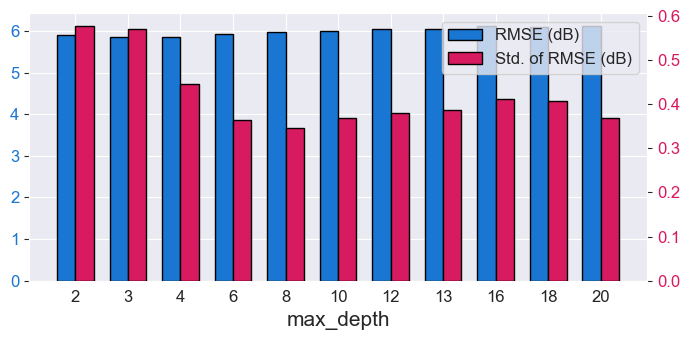

In [25]:
# ---- FONT SIZE METRICS ----
tick_fontsize = 12         # Tick label size
axis_labelsize = 15        # Axis label size
legend_fontsize = 12       # Legend font size

# ---- GLOBAL FONT FAMILY: Times New Roman ----
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Times New Roman'

sns.set_style("darkgrid")

x = np.arange(len(cv_df['max_depth']))
bar_width = 0.35

fig, ax1 = plt.subplots(figsize=(7, 3.5))

# Blue bars: Best CV RMSE (left y-axis)
bars1 = ax1.bar(
    x - bar_width/2, 
    cv_df['best_cv_rmse'], 
    bar_width, 
    color='#1976d2',
    label='RMSE',
    edgecolor='black',
    linewidth=1,
    zorder=3
)
#ax1.set_ylabel('RMSE (dB)', color='#1976d2', fontsize=axis_labelsize)
ax1.set_xlabel('max_depth', fontsize=axis_labelsize)
ax1.set_xticks(x)
ax1.set_xticklabels(cv_df['max_depth'], fontsize=tick_fontsize)
ax1.tick_params(axis='y', labelcolor='#1976d2', labelsize=tick_fontsize)
ax1.grid(True, axis='y')

# Magenta bars: STD of CV RMSE (right y-axis), offset to right
ax2 = ax1.twinx()
bars2 = ax2.bar(
    x + bar_width/2, 
    cv_df['std_cv_rmse'], 
    bar_width, 
    color='#d81b60',
    label='Std. of RMSE',
    edgecolor='black',
    linewidth=1,
    zorder=3
)
#ax2.set_ylabel('Std. of RMSE (dB)', color='#d81b60', fontsize=axis_labelsize)
ax2.tick_params(axis='y', labelcolor='#d81b60', labelsize=tick_fontsize)
ax2.grid(False)

# Single legend
handles = [
    plt.Rectangle((0,0),1,1,color='#1976d2',ec='black',label='RMSE (dB)'),
    plt.Rectangle((0,0),1,1,color='#d81b60',ec='black',label='Std. of RMSE (dB)')
]
ax1.legend(handles=handles, loc='upper right', fontsize=legend_fontsize)

fig.tight_layout()
plt.savefig('../../Comprehensive ML - Files & Plots etc/XGB_bestRMSE_&_STD_perDepth.png', dpi=2000, bbox_inches='tight')
plt.show()

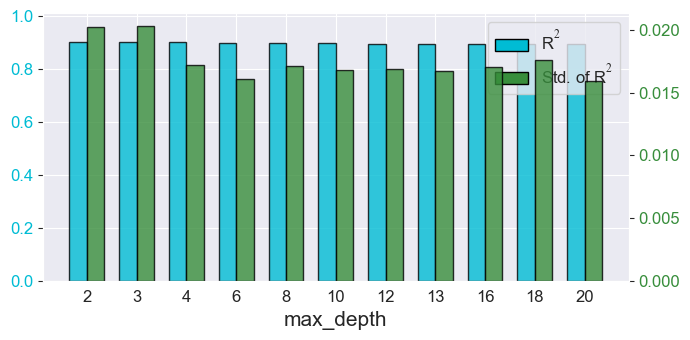

In [26]:
# ---- FONT SIZE METRICS ----
tick_fontsize = 12         # Tick label size
axis_labelsize = 15        # Axis label size
legend_fontsize = 12       # Legend font size

# ---- GLOBAL FONT FAMILY: Times New Roman ----
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Times New Roman'

sns.set_style("darkgrid")

x = np.arange(len(cv_df['max_depth']))
bar_width = 0.35

fig, ax1 = plt.subplots(figsize=(7, 3.5))

# --- Cyan bars: Best CV R² (left y-axis) ---
bars1 = ax1.bar(
    x - bar_width/2, 
    cv_df['best_cv_r2'], 
    bar_width, 
    color='#00bcd4',                # Cyan
    edgecolor='black',
    linewidth=1,
    alpha=0.8,
    label='R$^2$'
)
ax1.set_xlabel('max_depth', fontsize=axis_labelsize)
#ax1.set_ylabel('Best CV R$^2$', color='#00bcd4', fontsize=axis_labelsize)
ax1.set_xticks(x)
ax1.set_xticklabels(cv_df['max_depth'], fontsize=tick_fontsize)
ax1.tick_params(axis='y', labelcolor='#00bcd4', labelsize=tick_fontsize)
ax1.tick_params(axis='x', labelsize=tick_fontsize)
ax1.set_ylim(0, 1.01)
ax1.grid(True, axis='y')

# --- Green bars: STD of CV R² (right y-axis) ---
ax2 = ax1.twinx()
bars2 = ax2.bar(
    x + bar_width/2, 
    cv_df['std_cv_r2'], 
    bar_width, 
    color='#388e3c',                # Green
    edgecolor='black',
    linewidth=1,
    alpha=0.8,
    label='Std. of R$^2$'
)
#ax2.set_ylabel('Std. of CV R$^2$', color='#388e3c', fontsize=axis_labelsize)
ax2.tick_params(axis='y', labelcolor='#388e3c', labelsize=tick_fontsize)
ax2.grid(False)

# --- Combined Legend (top right, inside) ---
handles = [
    plt.Rectangle((0,0),1,1,color='#00bcd4',ec='black',label='R$^2$'),
    plt.Rectangle((0,0),1,1,color='#388e3c',ec='black',label='Std. of R$^2$')
]
ax1.legend(handles=handles, loc='upper right', fontsize=legend_fontsize)

fig.tight_layout()
#plt.savefig('../../Comprehensive ML - Files & Plots etc/XGB_bestR2_STD_perDepth.png', dpi=2000, bbox_inches='tight')
plt.show()

<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
 Train on All Training Data and Test Evaluation 
</p>

In [27]:
# Use built-in best_estimator_ (already refitted on full train data) and best_params_
best_model = bayes_cv.best_estimator_
best_params = bayes_cv.best_params_
print("Best Parameters Found:", best_params)

print("\nUsing best model from BayesSearchCV (already trained on all data)...")

y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_mape = mean_absolute_percentage_error(y_test, y_test_pred)
test_median_ae = median_absolute_error(y_test, y_test_pred)

results = pd.DataFrame({
    'Metric': [
        'Training Loss (MSE)', 'Test Loss (MSE)', 'Test RMSE',
        'R² Score (Train)', 'R² Score (Test)', 'Test MAPE (%)', 'Test Median AE'
    ],
    'Value': [
        train_mse, test_mse, test_rmse, train_r2, test_r2,
        test_mape * 100, test_median_ae
    ]
})

print("\nModel Evaluation Metrics:")
display(results)

# Ensure the directory exists
os.makedirs('Models', exist_ok=True)

# Save the trained XGBoost model
with open('../Models/xgb_final_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

print("Trained XGBoost model saved to Models/xgb_final_model.pkl")

Best Parameters Found: OrderedDict({'colsample_bylevel': 0.7984587999724674, 'colsample_bynode': 0.7533581511878504, 'colsample_bytree': 0.6777049700106795, 'gamma': 6.073209829746582, 'learning_rate': 0.0344504321529077, 'max_depth': 3, 'min_child_weight': 16.807767232338914, 'n_estimators': 263, 'reg_alpha': 3.0793754268758815, 'reg_lambda': 2.4295635114098553, 'subsample': 0.7207367212148637})

Using best model from BayesSearchCV (already trained on all data)...

Model Evaluation Metrics:


,Metric,Value
0,Training Loss (MSE),27.066511
1,Test Loss (MSE),26.177228
2,Test RMSE,5.116369
3,R² Score (Train),0.923547
4,R² Score (Test),0.926159
5,Test MAPE (%),4.454249
6,Test Median AE,3.093119


Trained XGBoost model saved to Models/xgb_final_model.pkl


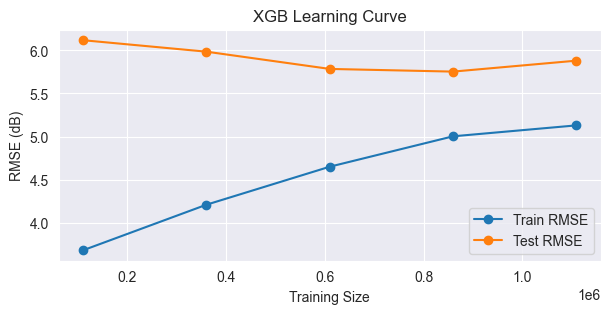

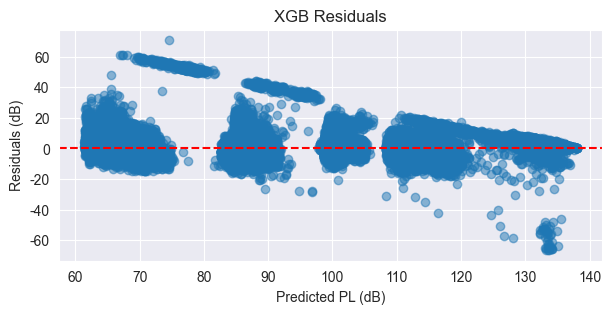

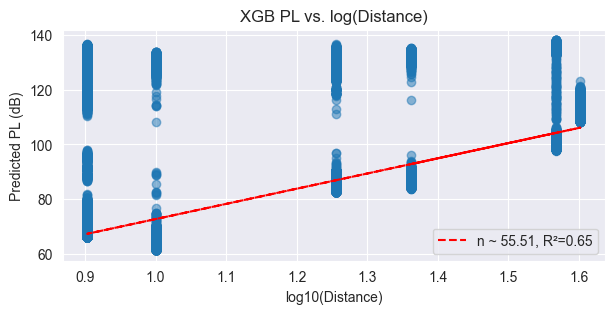

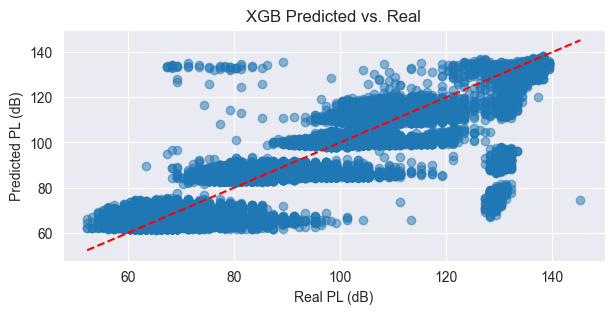

In [28]:
# Use best_model for plots
xgb_model = best_model

figsize = (7, 3)
path = '../../Comprehensive ML - Files & Plots etc/'

# 1. Learning Curve
train_sizes, train_scores, test_scores = learning_curve(xgb_model, X_train, y_train, cv=ps, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5), scoring='neg_root_mean_squared_error')
train_rmse = -train_scores.mean(1)
test_rmse = -test_scores.mean(1)
plt.figure(figsize=figsize)
plt.plot(train_sizes, train_rmse, 'o-', label='Train RMSE')
plt.plot(train_sizes, test_rmse, 'o-', label='Test RMSE')
plt.xlabel('Training Size')
plt.ylabel('RMSE (dB)')
plt.title('XGB Learning Curve')
plt.legend()
#plt.savefig(f'{path}XGB_learning_curve.png', dpi=300)
plt.show()

# 2. Residuals
y_test_pred = xgb_model.predict(X_test)
residuals = y_test - y_test_pred
plt.figure(figsize=figsize)
plt.scatter(y_test_pred, residuals, alpha=0.5)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Predicted PL (dB)')
plt.ylabel('Residuals (dB)')
plt.title('XGB Residuals')
#plt.savefig(f'{path}XGB_residuals.png', dpi=300)
plt.show()

# 3. Physics Consistency (PL vs. log(distance))
dist = df_test['distance'].values
log_dist = np.log10(dist + 1e-6)
slope, intercept, r_value, _, _ = linregress(log_dist, y_test_pred)
plt.figure(figsize=figsize)
plt.scatter(log_dist, y_test_pred, alpha=0.5)
plt.plot(log_dist, intercept + slope * log_dist, 'r--', label=f'n ~ {slope:.2f}, R²={r_value**2:.2f}')
plt.xlabel('log10(Distance)')
plt.ylabel('Predicted PL (dB)')
plt.title('XGB PL vs. log(Distance)')
plt.legend()
#plt.savefig(f'{path}XGB_physics_consistency.png', dpi=300)
plt.show()

# 4. Predicted vs. Real
plt.figure(figsize=figsize)
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Real PL (dB)')
plt.ylabel('Predicted PL (dB)')
plt.title('XGB Predicted vs. Real')
#plt.savefig(f'{path}XGB_pred_vs_real.png', dpi=300)
plt.show()